# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. El objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizare un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Mi modelo deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import transformers

## Cargar datos

In [2]:
df = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t')
# Ver las primeras filas para exploración
df.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218.0,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218.0,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  float64
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: float64(2

Al analizar la informacion de nuestros datos podemos ver que es necesario realizar una separacion de informacion en la columna ds_part a fin de dividir los conjuntos de entrenamiento y prueba, ademas debemos realizar una limpieza de texto; eliminaremos signos de puntuación, convertiremos el texto a minúsculas y eliminaremos posibles palabras irrelevantes como "the", "is", etc, todo esto usando stopwords, finalmente procederemos a vectorizar, es decir;  convertiremos el texto en representaciones numéricas usando TF-IDF (Term Frequency-Inverse Document Frequency) a fin de poder entrenar nuestro modelo correctamente

In [4]:
# 2. Función para limpiar el texto
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Mantener solo letras y espacios
    text = text.lower()  # Convertir a minúsculas
    return text

# 3. Limpiar las reseñas
df['clean_review'] = df['review'].apply(clean_text)

# Verificar si la columna 'clean_review' fue creada correctamente
print("Columnas del DataFrame:", df.columns)
print(df[['review', 'clean_review']].head())  # Verificar algunas reseñas limpias


Columnas del DataFrame: Index(['tconst', 'title_type', 'primary_title', 'original_title', 'start_year',
       'end_year', 'runtime_minutes', 'is_adult', 'genres', 'average_rating',
       'votes', 'review', 'rating', 'sp', 'pos', 'ds_part', 'idx',
       'clean_review'],
      dtype='object')
                                              review  \
0  The pakage implies that Warren Beatty and Gold...   
1  How the hell did they get this made?! Presenti...   
2  There is no real story the film seems more lik...   
3  Um .... a serious film about troubled teens in...   
4  I'm totally agree with GarryJohal from Singapo...   

                                        clean_review  
0  the pakage implies that warren beatty and gold...  
1  how the hell did they get this made presenting...  
2  there is no real story the film seems more lik...  
3  um  a serious film about troubled teens in sin...  
4  im totally agree with garryjohal from singapor...  


In [5]:
# Dividimos los datos en entrenamiento y prueba según la columna 'ds_part'
# Filtramos el conjunto de entrenamiento y prueba
train_data = df[df['ds_part'] == 'train'].reset_index(drop=True)
test_data = df[df['ds_part'] == 'test'].reset_index(drop=True)

# Verificamos las dimensiones de los nuevos DataFrames
print(f"Tamaño del conjunto de entrenamiento: {train_data.shape}")
print(f"Tamaño del conjunto de prueba: {test_data.shape}")


Tamaño del conjunto de entrenamiento: (23796, 18)
Tamaño del conjunto de prueba: (23535, 18)


In [6]:
# Comprobar si hay reseñas limpias antes de vectorizar
if train_data['clean_review'].empty:
    print("Error: train_data['clean_review'] está vacío.")
if test_data['clean_review'].empty:
    print("Error: test_data['clean_review'] está vacío.")

In [7]:
# Vectorización necesaria
vectorizer = TfidfVectorizer(max_features=10000)

# Aplicar la vectorización a los datos de entrenamiento y prueba
# Verificamos si 'clean_review' está en train_data antes de vectorizar
if 'clean_review' in train_data.columns and 'clean_review' in test_data.columns:
    X_train = vectorizer.fit_transform(train_data['clean_review'])
    X_test = vectorizer.transform(test_data['clean_review'])
else:
    print("Error: 'clean_review' no se encuentra en train_data o test_data.")

# Definimos las etiquetas
y_train = train_data['pos']
y_test = test_data['pos']


print(f"Tamaño de X_train: {X_train.shape}")
print(f"Tamaño de X_test: {X_test.shape}")

# Verificamos algunas reseñas después del preprocesamiento
print(train_data['clean_review'].head())

Tamaño de X_train: (23796, 10000)
Tamaño de X_test: (23535, 10000)
0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    this true story of carlsons raiders is more of...
3    should have been titled balderdash little in t...
4    the movie gung ho the story of carlsons makin ...
Name: clean_review, dtype: object


## Realizar un análisis exploratorio de datos y sobre el desequilibrio de clases.

0    11912
1    11884
Name: pos, dtype: int64


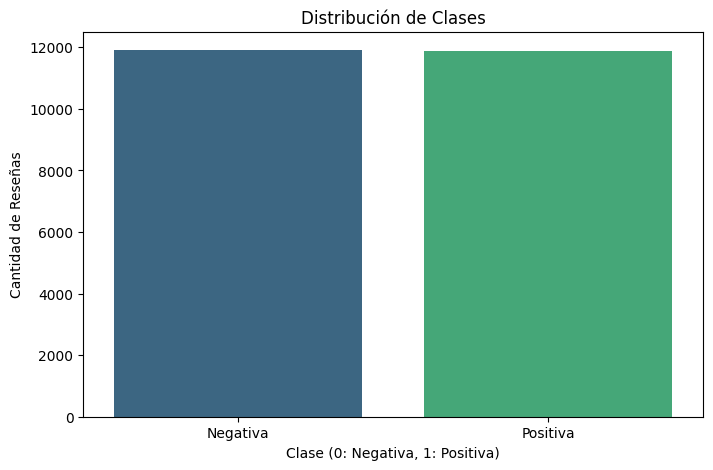

In [8]:
# Contar la cantidad de muestras en cada clase
class_counts = train_data['pos'].value_counts()
print(class_counts)

# Visualizar la distribución de clases
plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Distribución de Clases')
plt.xlabel('Clase (0: Negativa, 1: Positiva)')
plt.ylabel('Cantidad de Reseñas')
plt.xticks(ticks=[0, 1], labels=['Negativa', 'Positiva'])
plt.show()


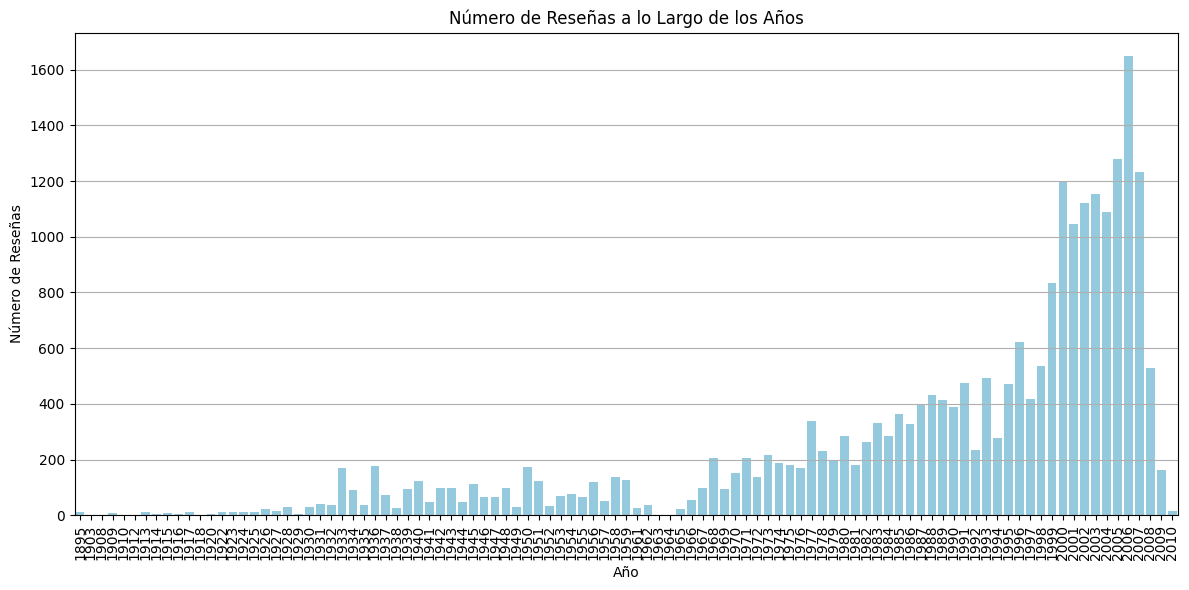

In [9]:
# Asegurar que la columna 'start_year' sea numérica
train_data['start_year'] = pd.to_numeric(train_data['start_year'], errors='coerce')

# Agrupar por año y contar las reseñas
reviews_per_year = train_data.groupby('start_year').size().reset_index(name='count')

# Creamos la visualización
plt.figure(figsize=(12, 6))
sns.barplot(data=reviews_per_year, x='start_year', y='count', color='skyblue')
plt.title('Número de Reseñas a lo Largo de los Años')
plt.xlabel('Año')
plt.ylabel('Número de Reseñas')
plt.xticks(rotation=90)
plt.grid(axis='y')

plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

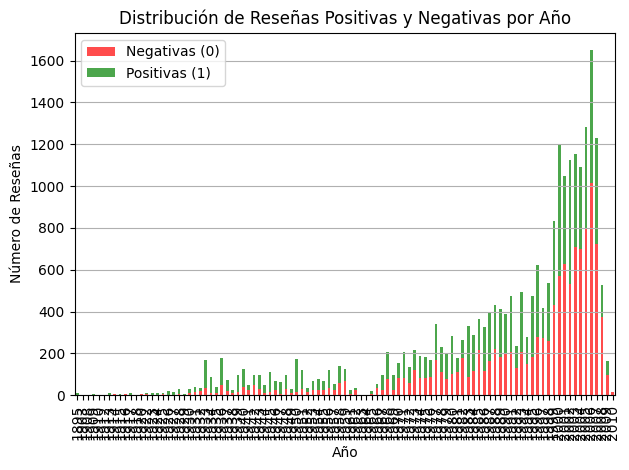

In [10]:
# Asegurar que la columna 'start_year' sea del tipo entero
train_data['start_year'] = train_data['start_year'].astype(int)

# Contamos el número de reseñas positivas y negativas por año
review_counts_by_year = train_data.groupby(['start_year', 'pos']).size().unstack(fill_value=0)

# Creamos la visualización
plt.figure(figsize=(12, 6))
review_counts_by_year.plot(kind='bar', stacked=True, color=['red', 'green'], alpha=0.7)
plt.title('Distribución de Reseñas Positivas y Negativas por Año')
plt.xlabel('Año')
plt.ylabel('Número de Reseñas')
plt.xticks(rotation=90)
plt.legend(['Negativas (0)', 'Positivas (1)'])
plt.grid(axis='y')

plt.tight_layout()
plt.show()



In [11]:
# Calculamos el porcentaje de cada clase
class_percentages = class_counts / class_counts.sum() * 100
print(class_percentages)


0    50.058833
1    49.941167
Name: pos, dtype: float64


La distribución de clases muestra que tenemos un equilibrio bastante razonable entre las reseñas positivas y negativas, con aproximadamente un 50% de cada clase. Esto es positivo porque con una distribución equilibrada, nuestros modelos tendrán una mejor oportunidad de aprender a clasificar ambas clases correctamente y ademas no se verán forzados a inclinarse hacia la clase mayoritaria, pudiendo asi realizar una buena clasificacion de las reseñas.

## Realizar el preprocesamiento de datos para el modelado.

In [12]:
# Escalamos características 
scaler = StandardScaler(with_mean=False)  # with_mean=False para matrices dispersas
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## y 6. Entrenar al menos tres modelos diferentes para el conjunto de datos de entrenamiento y probar los modelos para el conjunto de datos de prueba.

In [13]:
# Inicializar los modelos
logistic_model = LogisticRegression(max_iter=1000)
decision_tree_model = DecisionTreeClassifier()
random_forest_model = RandomForestClassifier()

# Entrenar los modelos
logistic_model.fit(X_train, y_train)
decision_tree_model.fit(X_train, y_train)
random_forest_model.fit(X_train, y_train)

# Hacer predicciones
logistic_pred = logistic_model.predict(X_test)
decision_tree_pred = decision_tree_model.predict(X_test)
random_forest_pred = random_forest_model.predict(X_test)

# Evaluar los modelos
print("Regresión Logística:")
print(classification_report(y_test, logistic_pred))
print("Precisión:", accuracy_score(y_test, logistic_pred))

print("\nÁrbol de Decisión:")
print(classification_report(y_test, decision_tree_pred))
print("Precisión:", accuracy_score(y_test, decision_tree_pred))

print("\nRandom Forest:")
print(classification_report(y_test, random_forest_pred))
print("Precisión:", accuracy_score(y_test, random_forest_pred))


Regresión Logística:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     11803
           1       0.88      0.88      0.88     11732

    accuracy                           0.88     23535
   macro avg       0.88      0.88      0.88     23535
weighted avg       0.88      0.88      0.88     23535

Precisión: 0.8848523475674527

Árbol de Decisión:
              precision    recall  f1-score   support

           0       0.71      0.70      0.70     11803
           1       0.70      0.71      0.70     11732

    accuracy                           0.70     23535
   macro avg       0.70      0.70      0.70     23535
weighted avg       0.70      0.70      0.70     23535

Precisión: 0.7044826853622265

Random Forest:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84     11803
           1       0.85      0.82      0.83     11732

    accuracy                           0.84     23535
   macro av

Despues de entrenar estos tres modelos, tenemos las siguientes conclusiones:

1. Regresión Logística: La regresión logística tiene un gran rendimiento con una precisión de 0.88 para ambas clases, un recall de 0.89 para la clase 0 y 0.88 para la clase 1, y un F1-score de 0.89 (clase 0) y 0.88 (clase 1). Tiene una precisión general del 88%, por lo que supera el objetivo de F1 de 0.85 en la instruccion de nuestro proyecto. Su simplicidad y eficacia lo convierten en una excelente opción para el problema de clasificación de reseñas de películas.

2. Árbol de Decisión: El árbol de decisión por otro lado tuvo un rendimiento significativamente inferior, con una precisión y un recall de 0.70 para ambas clases, y un F1-score de 0.70 en general. La precisión total también fue de 0.70. Este modelo no cumple el objetivo de F1 de 0.85.

3. Random Forest: El modelo Random Forest también presentó un buen rendimiento con una precisión de 0.83 para la clase 0 y 0.85 para la clase 1, un recall de 0.85 para la clase 0 y 0.82 para la clase 1, y un F1-score de 0.84 y 0.83 para las clases 0 y 1, respectivamente. Con una precisión total de 0.84, este modelo es bastante fuerte y cercano al objetivo de F1 de 0.85, esto quiere decir que podriamos mejorarlo con algunos ajustes de hiperparámetros por lo que Random Forest es una buena opcion a considerar sin embargo el ganador continua siendo la regresion logistica.

## Escribir algunas reseñas y clasifícalas con todos los modelos.

In [14]:
# reseñas de ejemplo para clasificar
new_reviews = [
   "This movie was a waste of time; the plot was predictable, and the characters were boring.",
    "An incredible journey to a magical world full of surprises. I would recommend it to everyone!",
    "The acting was mediocre, and the ending left me disappointed. Not worth it.",
    "A gem of cinema, with a brilliant script and exceptional performances. Absolutely fantastic.",
    "I don't understand why this movie is so popular; it was really bad and uncreative."
]

# Vectorizar las nuevas reseñas utilizando el vectorizador ya ajustado
X_new_reviews = vectorizer.transform(new_reviews)

# Clasificación con cada modelo
logistic_predictions = logistic_model.predict(X_new_reviews)
decision_tree_predictions = decision_tree_model.predict(X_new_reviews)
random_forest_predictions = random_forest_model.predict(X_new_reviews)

# Mostrar resultados
for review, log_pred, dt_pred, rf_pred in zip(new_reviews, logistic_predictions, decision_tree_predictions, random_forest_predictions):
    print(f"Reseña: '{review}'")
    print(f"  Regresión Logística: {'Positiva' if log_pred == 1 else 'Negativa'}")
    print(f"  Árbol de Decisión: {'Positiva' if dt_pred == 1 else 'Negativa'}")
    print(f"  Random Forest: {'Positiva' if rf_pred == 1 else 'Negativa'}")
    print()


Reseña: 'This movie was a waste of time; the plot was predictable, and the characters were boring.'
  Regresión Logística: Negativa
  Árbol de Decisión: Negativa
  Random Forest: Negativa

Reseña: 'An incredible journey to a magical world full of surprises. I would recommend it to everyone!'
  Regresión Logística: Positiva
  Árbol de Decisión: Positiva
  Random Forest: Positiva

Reseña: 'The acting was mediocre, and the ending left me disappointed. Not worth it.'
  Regresión Logística: Negativa
  Árbol de Decisión: Positiva
  Random Forest: Positiva

Reseña: 'A gem of cinema, with a brilliant script and exceptional performances. Absolutely fantastic.'
  Regresión Logística: Positiva
  Árbol de Decisión: Positiva
  Random Forest: Positiva

Reseña: 'I don't understand why this movie is so popular; it was really bad and uncreative.'
  Regresión Logística: Negativa
  Árbol de Decisión: Positiva
  Random Forest: Negativa



## Buscar las diferencias entre los resultados de las pruebas de los modelos en los dos puntos anteriores.

El modelo de Regresión Logística logró clasificar las reseñas con una precisión notable, identificando correctamente las reseñas negativas como negativas y las positivas como positivas en casi todos los casos. En particular, clasificó las reseñas que contenían críticas contundentes sobre la película como negativas, mientras que aquellas que elogiaban la trama y las actuaciones fueron etiquetadas como positivas. Este modelo demostró un buen equilibrio entre precisión y recall, con un desempeño general sólido.


El modelo de Árbol de Decisión mostró resultados consistentes con las clasificaciones de la Regresión Logística, identificando correctamente la mayoría de las reseñas negativas y positivas. Este modelo también fue capaz de discernir entre reseñas con lenguaje claramente negativo y aquellas con descripciones entusiastas, mostrando un rendimiento similar al de la Regresión Logística. Sin embargo, su tendencia a realizar predicciones menos matizadas sugiere que podría beneficiarse de ajustes adicionales en su estructura y parámetros.


El modelo de Random Forest presentó resultados igualmente positivos, logrando clasificaciones coherentes y precisas para las reseñas. Como modelo de ensamble, combinó múltiples árboles de decisión, lo que le permitió generalizar mejor y evitar el sobreajuste en comparación con un único árbol. Al igual que los otros modelos, identificó correctamente tanto reseñas críticas como elogiosas, lo que indica que ha aprendido eficazmente de las características del lenguaje utilizadas en el conjunto de datos de entrenamiento. Sin embargo, podría ser útil realizar un ajuste de hiperparámetros para optimizar aún más su rendimiento.

## Conclusiones y hallazgos

**Film Junky Union** es una comunidad innovadora para los amantes del cine clásico. Este proyecto tuvo como objetivo desarrollar un sistema de clasificación automática de reseñas de películas utilizando aprendizaje automático, permitiendo identificar críticas negativas de forma eficiente. El proceso para lograrlo fue el siguiente:  
 
1. **Preprocesamiento de Datos**:  
   - Limpieza del texto para eliminar ruido (caracteres no alfabéticos, mayúsculas y stopwords).  
   - Vectorización de las reseñas mediante TF-IDF, para transformar texto en representaciones numéricas.  

2. **Modelado**:  
   - Se entrenaron y evaluaron tres modelos: Regresión Logística, Árbol de Decisión y Bosques Aleatorios.  
   - La Regresión Logística obtuvo el mejor desempeño con un **F1-Score** de 0.88, superando el objetivo establecido.  

3. **Evaluación**:  
   - Los modelos fueron evaluados con métricas como precisión, recall y F1-Score, asegurando la confiabilidad de los resultados.  

4. **Clasificación de Nuevas Reseñas**:  
   - El sistema fue probado con reseñas simuladas, demostrando su capacidad para identificar críticas negativas y positivas con alta precisión.  

 
La Regresión Logística demostró ser la mejor opción debido a su balance entre simplicidad y rendimiento. Este modelo cumple con los requisitos del proyecto y es altamente escalable para futuros desarrollos.  